# Teoria da Decisão - ELE088

*Prof. Lucas S. Batista*  
*Departamento de Engenharia Elétrica*  
*Universidade Federal de Minas Gerais* 

# Estudo de Caso

## Problema da Mochila Multiobjetivo Binário:

- Considere $n$ projetos, $m$ objetivos e um capital de investimento $b$. O projeto $j$ tem um custo $a_j$ e um retorno esperado $p_{ij}$ de acordo com o $i$-ésimo objetivo. Formule um problema que permita selecionar o portfólio de projetos que maximiza o retorno de cada um dos objetivos sem exceder os recursos disponíveis.

## Modelagem do problema

Assumindo que $x_{j}$ represente as variáveis de otimização do problema, pode-se definir que se $x_{j} = 1$, então o projeto $j$ é selecionado; caso contrário, i.e., se $x_{j} = 0$, então o $j$-ésimo projeto não é escolhido.

Com o intúito de maximizar o retorno total do portifólio de projetos, pode-se escrever as seguintes funções objetivo:

$$ \max_x \sum_{j=1}^{n} p_{ij} x_{j}, ~~~ \forall i \in \{1, 2, \ldots, m\} $$

Adicionalmente, este problema apresenta o seguinte conjunto de restrições:

\begin{align} 
\sum_{j=1}^{n} a_j x_j \leq b, \hspace{2cm} (R1) \\
x_{j} \in \{0, 1\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R2)
\end{align}

em que **R1** assegura que o portifólio de projetos escolhidos não ultrapassará o limite de capital disponível; e **R2** define o domínio das variáveis de decisão $x_{j}$.

## Otimização de uma instância arbitrária do problema via RVNS

A seguir são apresentados os trechos de código da implementação do RVNS para o estudo de caso apresentado.

In [4]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy
from rvns import rvns_approach

'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
class Struct:
    pass

Os dados da instância teste são definidos a seguir. Note que considera-se um número de projetos *default* $n = 50$. Além disso, assume-se um vetor de custos $a$ em que o custo de investimento em um projeto $j$ é dado na posição $a_j$; de forma semelhante, tem-se uma matriz de retornos $p$ em que o retorno financeiro de um projeto $j$ em relação ao objetivo $i$ é dado na posição $p_{ij}$. O capital de investimento disponível é informado em $b$.

In [5]:
'''
Define os dados de uma instância arbitrária do problema
'''
def probdef(m=2,n=50):
    
    # m: número de objetivos considerados
    # n: número de projetos considerados
        
    '''
    Capital disponível: b
    Vetor de custos:    a = [a1 a2 ... an]
    Matriz de retornos: p = [p11 ... p1n
                             p21 ...
                                 ...
                             pm1 ... pmn]    
    '''
    
    np.random.seed(13) 
    a = np.random.randint(10,100,size=n)        # considera custos inteiros aleatórios no conjunto {10, 11, ..., 99}
    p = 10*np.random.randint(10,100,size=(m,n)) # considera retornos inteiros aleatórios no conjunto 10*{10, 11, ..., 99}
    b = 0.6*a.sum(axis=0) # capital disponível igual a 60% do montante necessário para investir em todos os projetos
    np.random.seed()
    
    probdata = Struct()
    probdata.a = a
    probdata.p = p
    probdata.b = b
    probdata.m = m
    probdata.n = n
    
    return probdata

Uma solução candidata $x = (x_1, x_2, ..., x_n)$ para o problema foi modelada computacionalmente como um vetor binário, em que $x_j = 1$ indica aporte de investimento no $j$-ésimo projeto; caso contrário, $x_j = 0$.

In [6]:
'''
Implementa uma solução inicial para o problema
'''
def sol_inicial(probdata,w,apply_constructive_heuristic):
    
    '''  
    Modelou-se uma solução x como um vetor binário
    
    x = [x1 x2 ... xn]
    '''
    
    if apply_constructive_heuristic == False: 
        # Constrói solução inicial aleatoriamente
        x = Struct()    
        x.solution = np.random.randint(0,2,size=probdata.n)    
    
    else:
        # Constrói solução inicial usando uma heurística construtiva
        x = Struct()
        x.solution = np.zeros(shape=probdata.n,dtype=int)        
        weighted_profit = np.dot(w, probdata.p)        
        sorted_projects = np.argsort(weighted_profit - probdata.a) # projetos ordenados assumindo a diferença 'wpj - aj' 

        custo_acumulado = 0.0                   # inclue os melhores projetos até atingir o capital limite
        for proj in sorted_projects[::-1]:
            custo_acumulado += probdata.a[proj]
            if custo_acumulado <= probdata.b:
                x.solution[proj] = 1
            else:
                break
        
    return x

A função objetivo é implementada conforme a definição apresentada anteriormente. De forma geral, dada uma solução $x$, que indica os projetos escolhidos para investimento, esta função computa o somatório dos retornos para cada um dos objetivos.

In [7]:
'''
Implementa a função objetivo do problema
'''
def obj_functions(x, probdata):
    
    ''' 
    x = [x1 x2 ... xn]
    '''
    
    sol     = np.transpose(np.array(x.solution))       # vetor solução transposto
    retorno = np.array(probdata.p)                     # matriz com os retornos
    custo   = np.array(probdata.a)                     # vetor com os custos
    
    x.g = np.dot(custo, sol) - probdata.b                      # valor da restrição R2 para a solução x    
    penalidade = 100*np.sum(np.where(x.g <= 0, 0, x.g)**2)     # penalidade aplicada sobre a solução x
    
    x.fitness = list()
    x.fitness_penalizado = list()
    for i in np.arange(0,probdata.m,1):
        fit = - np.dot(retorno[i,:], sol)              # transforma função de maximização em minimização
        x.fitness.append(fit)                          # negativo do retorno da solução x para o i-ésimo objetivo
        x.fitness_penalizado.append(fit + penalidade)  # negativo do retorno penalizado da solução x para o objetivo i
        
    return x

A função soma ponderada é implementada a seguir.

In [8]:
'''
Implementa a função soma ponderada
'''
def Pw_function(x, approachinfo, probdata):
    
    x = obj_functions(x, probdata)
    x.single_objective_value = np.dot(approachinfo.w, np.transpose(np.array(x.fitness_penalizado)))
    
    return x

A função a seguir retorna apenas as soluções não-dominadas.

In [9]:
'''
Implementa a função 'non-dominated sorting' (considera minimização)
'''
def nondominatedsolutions(f):
    
    N = np.shape(f)[0]    
    nondominatedsolindex = np.ones(N,dtype=int)  # armazena o índice das soluções não-dominadas
    for i in np.arange(0,N,1):
        for j in np.arange(0,N,1):
            if j == i:
                continue
            if np.all(np.array(f[j,:]) <= np.array(f[i,:]))==True and np.any(np.array(f[j,:]) < np.array(f[i,:]))==True:
                nondominatedsolindex[i] = 0  # solução i é dominada
                break
        
    return nondominatedsolindex

### Estrutura principal da estratégia Soma Ponderada ($P_w$)

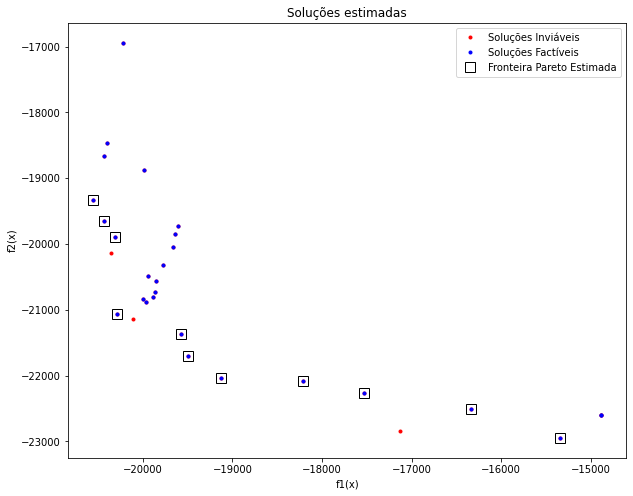

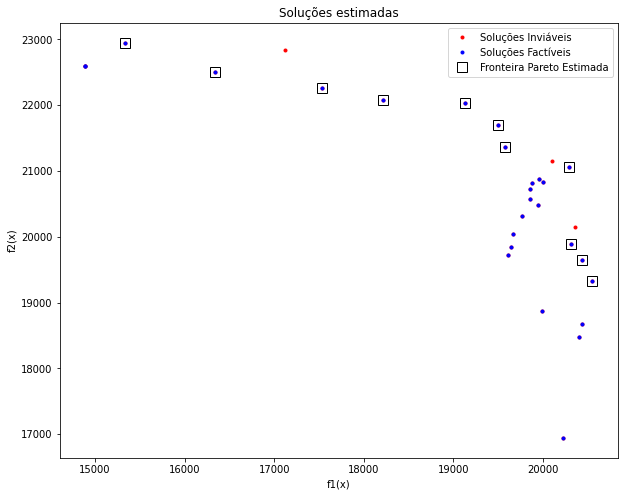

In [10]:
'''
Implementa a estratégia Pw
'''

# Faz a leitura dos dados da instância do problema
probdata = probdef(m=2,n=50)

# Armazena dados para plot
archive = Struct()
archive.g = []
archive.sol = []
archive.fitpen = []

# Armazena dados da estratégia de otimização mono-objetivo
approachinfo = Struct()


N = 30                                     # número desejado de soluções Pareto-ótimas ESTIMADAS
for i in np.arange(0,N,1):                 # cada iteração mapeia uma solução na fronteira estimada
    
    w = np.random.random(size=probdata.m)  # gera um vetor de pesos aleatórios
    w = w/sum(w)                           # normaliza o vetor de pesos (i.e., sum(w) = 1)
    
    # Gera solução inicial
    x = sol_inicial(probdata,w,apply_constructive_heuristic=True)
    
    approachinfo.w = w
    x = rvns_approach(Pw_function, x, probdata, approachinfo, maxeval=1000)
    
    archive.g.append(x.g)
    archive.sol.append(x.solution)
    archive.fitpen.append(x.fitness_penalizado)


f = np.array(archive.fitpen)
g = np.array(archive.g)
F = copy.deepcopy(f[g<=0,:])        # faz uma cópia somente das soluções viáveis
NDindex = nondominatedsolutions(F)  # índices das soluções não-dominadas        
    
if probdata.m == 2:
    plt.figure(figsize=(10,8))
    plt.plot(f[:,0],f[:,1],'r.')
    plt.plot(f[g<=0,0],f[g<=0,1],'b.')
    plt.plot(F[NDindex==1,0],F[NDindex==1,1],'ks',markerfacecolor='none',markersize=10)    
    plt.legend(['Soluções Inviáveis', 'Soluções Factíveis', 'Fronteira Pareto Estimada'])
    plt.title('Soluções estimadas')
    plt.xlabel('f1(x)')
    plt.ylabel('f2(x)')
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.plot(-f[:,0],-f[:,1],'r.')
    plt.plot(-f[g<=0,0],-f[g<=0,1],'b.')     
    plt.plot(-F[NDindex==1,0],-F[NDindex==1,1],'ks',markerfacecolor='none',markersize=10)
    plt.legend(['Soluções Inviáveis', 'Soluções Factíveis', 'Fronteira Pareto Estimada'])
    plt.title('Soluções estimadas')
    plt.xlabel('f1(x)')
    plt.ylabel('f2(x)')
    plt.show()
    
elif probdata.m == 3:    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')    
    ax.plot3D(f[:,0],f[:,1],f[:,2],'r.')
    ax.plot3D(f[g<=0,0],f[g<=0,1],f[g<=0,2],'b.')      
    ax.plot3D(F[NDindex==1,0],F[NDindex==1,1],F[NDindex==1,2],'ks',markerfacecolor='none',markersize=10)    
    ax.legend(['Soluções Inviáveis', 'Soluções Factíveis', 'Fronteira Pareto Estimada'])
    plt.title('Soluções estimadas')
    ax.set_xlabel('f1(x)')
    ax.set_ylabel('f2(x)')
    ax.set_zlabel('f3(x)')
    plt.show()
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')    
    ax.plot3D(-f[:,0],-f[:,1],-f[:,2],'r.')
    ax.plot3D(-f[g<=0,0],-f[g<=0,1],-f[g<=0,2],'b.')    
    ax.plot3D(-F[NDindex==1,0],-F[NDindex==1,1],-F[NDindex==1,2],'ks',markerfacecolor='none',markersize=10)
    ax.legend(['Soluções Inviáveis', 'Soluções Factíveis', 'Fronteira Pareto Estimada'])
    plt.title('Soluções estimadas')
    ax.set_xlabel('f1(x)')
    ax.set_ylabel('f2(x)')
    ax.set_zlabel('f3(x)')
    plt.show()
